### Analisi tecnica

### Backtesting medie mobili semplici ed esponenziali (MACD)
Fonte: https://www.youtube.com/watch?v=7_dxjNx2PdE&list=PLLDx60G0MrKZ66gCSCM0wvBYKfIXzv7GA&index=3&ab_channel=Pythonenthusiast


Questa forse la strategia più utilizzata[1] dagli analisti e prevede di generare segnali all'incrocio tra due medie mobili (doppio crossover); vengono utilizzate due medie, ovviamente di periodo differente. Quando quella più veloce, ovvero generata da un periodo minore, incrocerà al rialzo quella più lenta verrà generato un segnale di acquisto; viceversa quando quella lenta sarà tagliata al ribasso da quella più veloce si avrà la vendita. Anche qui i periodi scelti per la creazione delle medie mobili avranno effetto sui segnali generati: se si vorrà seguire andamenti di maggiore respiro sarà necessario aumentare i periodi delle due medie mobili, mentre se si vorranno cavalcare i movimenti di breve periodo si potranno utilizzare due medie mobili più veloci.
Fonte: Wikipedia

In [ ]:
import pandas_datareader.data as web
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import numpy as np

style.use('ggplot')

Importiamo i dati

In [ ]:
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2020,9,7)
ticker = 'AAPL'
data = web.DataReader(ticker, 'yahoo', start, end)
data = data.drop(columns = ['High', 'Low', 'Open', 'Close'])

Creiamo le due serie di medie mobili, una a 20 giorni (1 mese circa) una a 120 giorni (6 mesi circa)

In [ ]:

data['SMA20'] = data['Adj Close'].rolling(20).mean()
data['SMA120'] = data['Adj Close'].rolling(120).mean()


In [ ]:
data.head()

,Volume,Adj Close,SMA20,SMA120
Date,,,,
2015-01-02,212818400.0,24.745996,NaN,NaN
2015-01-05,257142000.0,24.048859,NaN,NaN
2015-01-06,263188400.0,24.051128,NaN,NaN
2015-01-07,160423600.0,24.388376,NaN,NaN
2015-01-08,237458000.0,25.325432,NaN,NaN


Grafico della serie originale e delle due medie mobili

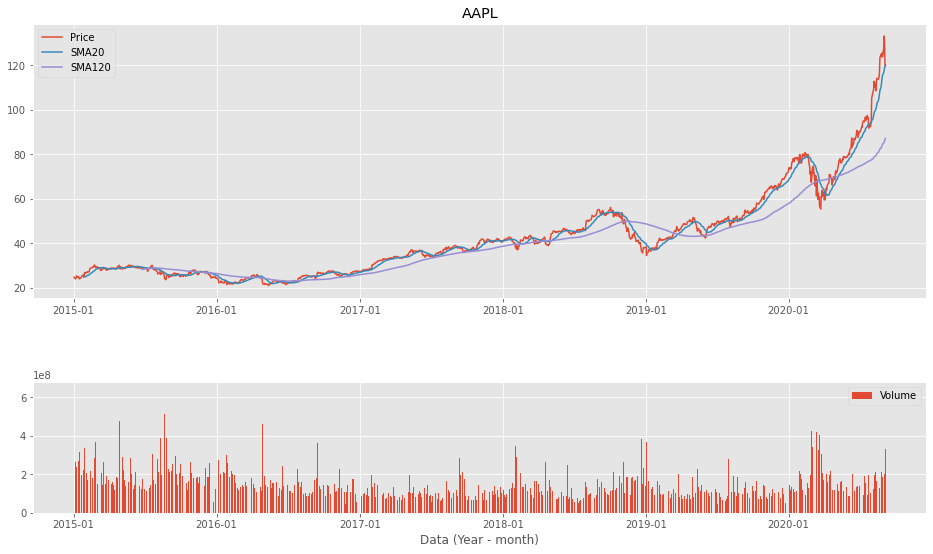

In [ ]:

plt.figure(figsize=(16,9))
ax1 = plt.subplot2grid((7,1), (0,0), rowspan = 4, colspan = 1, title = ticker)
ax2 = plt.subplot2grid((7,1), (5,0), rowspan = 2, colspan = 1, sharex = ax1)
ax1.plot(data['Adj Close'], label = 'Price')
ax1.plot(data['SMA20'], label = 'SMA20')
ax1.plot(data['SMA120'], label = 'SMA120')

ax2.bar(data.index, data['Volume'], label = 'Volume')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.set_xlabel('Data (Year - month)')
ax1.legend()
ax2.legend();


Creiamo la strategia

In [ ]:
data['Price_yesterday'] = data['Adj Close'].shift(1)
data['Change'] = data['Adj Close'] / data['Price_yesterday']
data['Invested_SMA'] = [1 if data.loc[i, 'SMA20'] > data.loc[i, 'SMA120'] 
                        else 0 for i in data.index]

Rendimento della strategia

In [ ]:
sma = data[data['Invested_SMA'] == 1]

In [ ]:
sma['Return'] = np.cumprod(sma['Change'])

<ipython-input-11-610d5bcff2d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma['Return'] = np.cumprod(sma['Change'])


In [ ]:
sma['rtn'] =sma['Return'].pct_change()

<ipython-input-14-f960f28f394f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma['rtn'] =sma['Return'].pct_change()


In [ ]:
sma['rtn'].std()*np.sqrt(252)

0.27674752969952476

In [ ]:
sma['rtn'].mean()*252 / (sma['rtn'].std()*np.sqrt(252))

1.1601849927095373

Rendimento del buy and hold

In [ ]:
data['Buy_and_hold'] = np.cumprod(data['Change'])
data['rtn'] = data['Buy_and_hold'].pct_change()
data['rtn'].std()

0.01832924369689981

In [ ]:
data['rtn'].mean()*252 / (data['rtn'].std()*np.sqrt(252))

1.1210590965216563

Confronto fra i due

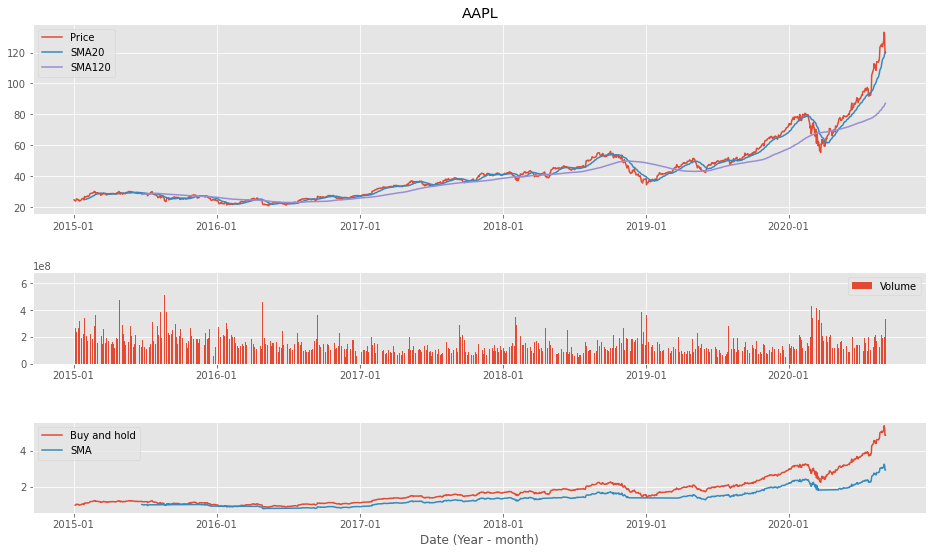

In [ ]:
plt.figure(figsize=(16,9))
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1, title = ticker)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 2, colspan = 1, sharex = ax1)
ax3 = plt.subplot2grid((10,1), (8,0), rowspan = 2, colspan = 1, sharex = ax1)
ax1.plot(data['Adj Close'], label = 'Price')
ax1.plot(data['SMA20'], label = 'SMA20')
ax1.plot(data['SMA120'], label = 'SMA120')

ax2.bar(data.index, data['Volume'], label = 'Volume')
ax3.plot(data['Buy_and_hold'], label = 'Buy and hold')
ax3.plot(sma['Return'], label = 'SMA')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax3.set_xlabel('Date (Year - month)')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()


In [ ]:
data['Buy_and_hold'][-1]

4.849747137146054

In [ ]:
sma['Return'][-1]

2.925682360345772

Medie mobili esponenziali

In [ ]:
data['EWM12'] = data['Adj Close'].ewm(span=12, adjust=False).mean()
data['EWM26'] = data['Adj Close'].EWM(span=26, adjust=False).mean()
data['Invested_EWM'] = [1 if data.loc[i, 'EWM12'] > data.loc[i, 'EWM26'] 
                        else 0 for i in data.index]
ewm = data[data['Invested_EWM'] == 1]
ewm['Return'] = np.cumprod(ewm['Change'])

<ipython-input-32-cde320473d3f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ewm['Return'] = np.cumprod(ewm['Change'])


Confronto delle tre strategie

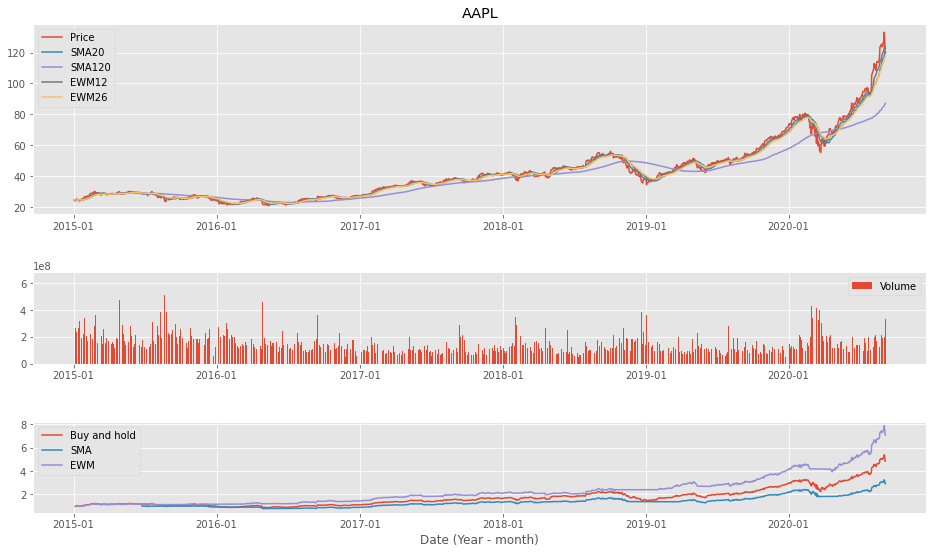

In [ ]:
plt.figure(figsize=(16,9))
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1, title = ticker)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 2, colspan = 1, sharex = ax1)
ax3 = plt.subplot2grid((10,1), (8,0), rowspan = 2, colspan = 1, sharex = ax1)
ax1.plot(data['Adj Close'], label = 'Price')
ax1.plot(data['SMA20'], label = 'SMA20')
ax1.plot(data['SMA120'], label = 'SMA120')
ax1.plot(data['EWM12'], label = 'EWM12')
ax1.plot(data['EWM26'], label = 'EWM26')

ax2.bar(data.index, data['Volume'], label = 'Volume')
ax3.plot(data['Buy_and_hold'], label = 'Buy and hold')
ax3.plot(sma['Return'], label = 'SMA')
ax3.plot(ewm['Return'], label ='EWM')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax3.set_xlabel('Date (Year - month)')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()


### Simulazione con più titoli

In [ ]:
tickers = ['AAPL', 'KO', 'MSFT', 'TSLA', 'AMZN']
for ticker in tickers:
    data = web.DataReader(ticker, 'yahoo', start, end)
    data = data.drop(columns = ['High', 'Low', 'Open', 'Close'])
    data['SMA20'] = data['Adj Close'].rolling(20).mean()
    data['SMA120'] = data['Adj Close'].rolling(120).mean()
    data['EWM12'] = data['Adj Close'].ewm(span=12, adjust=False).mean()
    data['EWM26'] = data['Adj Close'].ewm(span=26, adjust=False).mean()
    data['Price_yesterday'] = data['Adj Close'].shift(1)
    data['Change'] = data['Adj Close'] / data['Price_yesterday']
    data['Invested_SMA'] = [1 if data.loc[i, 'SMA20'] > data.loc[i, 'SMA120'] 
                        else 0 for i in data.index]
    data['Invested_EWM'] = [1 if data.loc[i, 'EWM12'] > data.loc[i, 'EWM26'] 
                        else 0 for i in data.index]
    data['Buy_and_hold'] = np.cumprod(data['Change'])
    sma = data[data['Invested_SMA'] == 1]
    sma['Return'] = np.cumprod(sma['Change'])
    ewm = data[data['Invested_EWM'] == 1]
    ewm['Return'] = np.cumprod(ewm['Change'])
    print('Buy and hold strategy return: ' + ticker + ' '+   str(data['Buy_and_hold'][-1]))
    print('SMA return: ' + ticker + ' ' + str(sma['Return'][-1]))
    print('EWM return: ' + ticker + ' ' + str(ewm['Return'][-1]))


<ipython-input-41-7ef6a0790eb0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma['Return'] = np.cumprod(sma['Change'])
<ipython-input-41-7ef6a0790eb0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ewm['Return'] = np.cumprod(ewm['Change'])


Buy and hold strategy return: AAPL 4.849747884754674
SMA return: AAPL 2.9256846922567186
EWM return: AAPL 7.08596558009989


<ipython-input-41-7ef6a0790eb0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma['Return'] = np.cumprod(sma['Change'])
<ipython-input-41-7ef6a0790eb0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ewm['Return'] = np.cumprod(ewm['Change'])


Buy and hold strategy return: KO 1.4511659268897747
SMA return: KO 1.164716892896128
EWM return: KO 1.450518594102331


ConnectionError: HTTPSConnectionPool(host='finance.yahoo.com', port=443): Max retries exceeded with url: /quote/MSFT/history?period1=1420081200&period2=1599530399&interval=1d&frequency=1d&filter=history (Caused by NewConnectionError("<urllib3.connection.HTTPSConnection object at 0x0000016A5D5FA3A0>: Failed to establish a new connection: [WinError 10060] Impossibile stabilire la connessione. Risposta non corretta della parte connessa dopo l'intervallo di tempo oppure mancata risposta dall'host collegato"))

### Relative Strength Index (RSI)

Il Relative Strength Index (RSI), o indice di forza relativa, è uno fra gli oscillatori più popolari dell'analisi tecnica e comunemente usati dai traders, in particolar modo da quelli che operano sui mercati dei futures. Fu ideato da John Welles Wilder, che lo pubblicò nel suo libro New Concepts in Technical Trading System nel 1978.

Si tratta di un indicatore di momentum, che riesce però ad ovviare ad alcuni problemi presenti nel momentum, nel Rate of change o in altri oscillatori di questo tipo. Questi generano notevoli complicazioni nella loro interpretazione, soprattutto quando si verificano bruschi movimenti del mercato causandone un'improvvisa inversione della linea. È quindi necessario, per una corretta e più comprensibile analisi, minimizzare queste distorsioni.

Il Relative Stregth Index, oltre a risolvere questo problema, presenta una banda d'oscillazione costante, da 0 a 100, che permette una comparazione dei valori con alcuni livelli costanti prestabiliti.

Va comunque sottolineato come il termine "indice di forza relativa" sia improprio, generando confusione anche in chi lo utilizza regolarmente. Infatti, con "forza relativa" solitamente si intende un grafico lineare che mette in rapporto due differenti entità, come per esempio un'azione e il suo indice di appartenenza, due indici settoriali, una materia prima e un cambio monetario, ecc. L'indice ideato da Wilder non misura alcuna di queste correlazioni, traendo quindi in inganno.

Fonte: Wikipedia

In [ ]:
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2020,9,7)
tickers = ['AAPL', 'KO', 'MSFT', 'TSLA', 'AMZN']
ticker = 'KO'
data = web.DataReader(ticker, 'yahoo', start, end)
data = data.drop(columns = ['High', 'Low', 'Open', 'Close'])

In [ ]:
data['abs_change'] = data['Adj Close'].diff(1)
data['up'] = [1 if data.loc[i, 'abs_change'] >  0 else 0 for i in data.index]
data['down'] = [1 if data.loc[i, 'abs_change'] <  0 else 0 for i in data.index]

In [ ]:
data['positive_movement'] = data['up'] * data['abs_change']
data['negative_movement'] = data['down'] * data['abs_change'] * - 1

In [ ]:
data['avg_gain'] = data['positive_movement'].rolling(14).mean()
data['avg_loss'] = data['negative_movement'].rolling(14).mean()

In [ ]:
data['RS'] = data['avg_gain'] / data['avg_loss']
data['RSI'] = 100 - (100 / (1 + data['RS']))

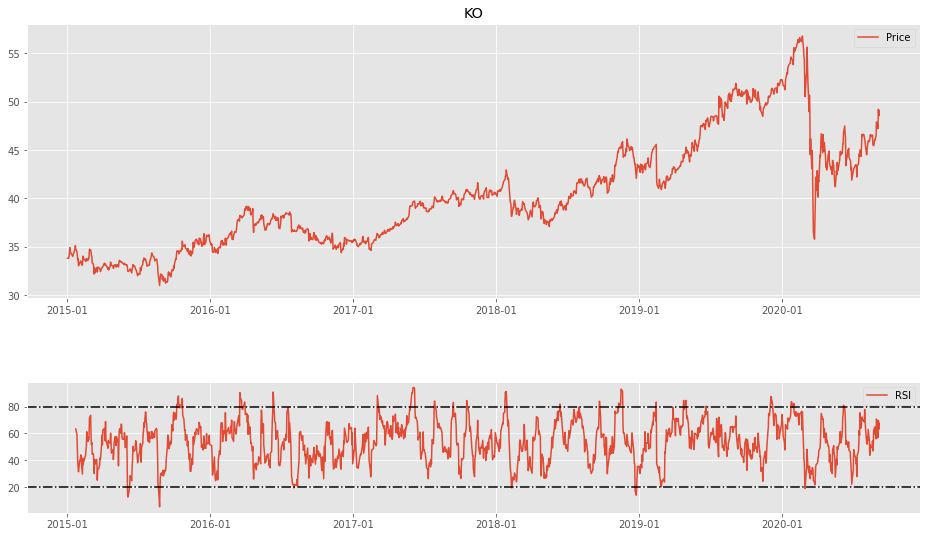

In [ ]:
plt.figure(figsize=(16,9))
ax1 = plt.subplot2grid((7,1), (0,0), rowspan = 4, colspan = 1, title = ticker)
ax2 = plt.subplot2grid((7,1), (5,0), rowspan = 2, colspan = 1, sharex = ax1)
ax1.plot(data['Adj Close'], label = 'Price')
ax2.plot(data['RSI'], label = 'RSI')
ax2.axhline(80, linestyle = '-.', color = 'black')
ax2.axhline(20, linestyle = '-.', color = 'black')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.legend()
ax2.legend()
plt.show()         

#### RSI - Simulazione con più titoli

In [ ]:
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2020,9,7)
tickers = ['AAPL', 'KO', 'MSFT', 'TSLA', 'AMZN','BAC']
results = pd.DataFrame(columns = ['Ticker', 'RSI'])


In [ ]:
for ticker in tickers:
    data = web.DataReader(ticker, 'yahoo', start, end)
    data = data.drop(columns = ['High', 'Low', 'Open', 'Close'])
    data['abs_change'] = data['Adj Close'].diff(1)
    data['up'] = [1 if data.loc[i, 'abs_change'] >  0 else 0 for i in data.index]
    data['down'] = [1 if data.loc[i, 'abs_change'] <  0 else 0 for i in data.index]
    data['positive_movement'] = data['up'] * data['abs_change']
    data['negative_movement'] = data['down'] * data['abs_change'] * - 1
    data['avg_gain'] = data['positive_movement'].rolling(14).mean()
    data['avg_loss'] = data['negative_movement'].rolling(14).mean()
    data['RS'] = data['avg_gain'] / data['avg_loss']
    data['RSI'] = 100 - (100 / (1 + data['RS']))
    
    new_row = {'Ticker': ticker, 'RSI': data['RSI'][-1]}
    results = results.append(new_row, ignore_index = True)
    

In [ ]:
print(results)

  Ticker        RSI
0   AAPL  58.261270
1     KO  67.534065
2   MSFT  54.328428
3   TSLA  59.780367
4   AMZN  57.022879
5    BAC  58.107106


### Bande di Bollinger

Le bande di Bollinger si basano sulla volatilità di un titolo. La volatilità può essere vista come la deviazione standard (standard deviation) - statisticamente definita come scarto quadratico medio o radice quadrata della varianza.


Grafico giornaliero (daily) del titolo Mediobanca con le bande di Bollinger a 20 periodi con una deviazione 2.
Per calcolare le bande di Bollinger si usa dapprima una media mobile a G giorni (spesso 20) a cui viene aggiunto o sottratto il valore della deviazione standard moltiplicata per un determinato fattore F (spesso intorno a 2).

La banda superiore è quindi ottenuta aggiungendo alla media mobile F volte la deviazione standard. La banda centrale (se la si vuole visualizzare) è data dalla media mobile. La banda inferiore è calcolata sottraendo alla media mobile F volte la deviazione standard.

Una maggiore ampiezza delle bande corrisponde a un'alta volatilità. Una minore ampiezza corrisponde viceversa a una bassa volatilità. Bande convergenti rappresentano volatilità in diminuzione. Bande divergenti rappresentano volatilità in aumento.

È possibile variare leggermente i parametri G ed F. Valori che secondo lo stesso Bollinger possono essere utilizzati sono i seguenti:

G = 20 e F = 2 Valido in generale;
G = 10 e F = 1.9 Se c'è la necessità di usare una media mobile molto corta;
G = 50 e F = 2.1 Se c'è la necessità di usare una media mobile molto lunga.
Lo stesso John Bollinger consiglia di non variare la lunghezza della Media Mobile (G) ma piuttosto di passare da barre daily a barre settimanali o mensili (per trading a lungo termine) o a barre di 1 ora o 5 minuti (per trading intraday).

Approssimativamente, dal punto di vista operativo, le bande di Bollinger danno segnali di acquisto e vendita quando si verificano le seguenti condizioni:

- quando il grafico del prezzo esce dalla banda superiore e successivamente vi rientra, si ottiene un segnale di vendita; questo corrisponde a un rapido aumento del prezzo e a un successivo rallentamento o aggiustamento;
- quando il grafico del prezzo esce dalla banda inferiore e successivamente vi rientra, si ottiene un segnale di acquisto; cioè il prezzo è calato molto velocemente fino ad arrestarsi e -probabilmente- a invertire il trend.

In realtà le bande di Bollinger da sole possono dare falsi segnali in quanto per esempio il grafico potrebbe uscire in basso, rientrare e continuare il trend discendente. Per questo motivo, John Bollinger consiglia di utilizzare altri indicatori, non correlati, per testare il comportamento delle bande. Quando 2 o più indicatori confermano il comportamento delle bande, allora il segnale acquista significato (sempre nei limiti della relativa validità predittiva della Analisi Tecnica).

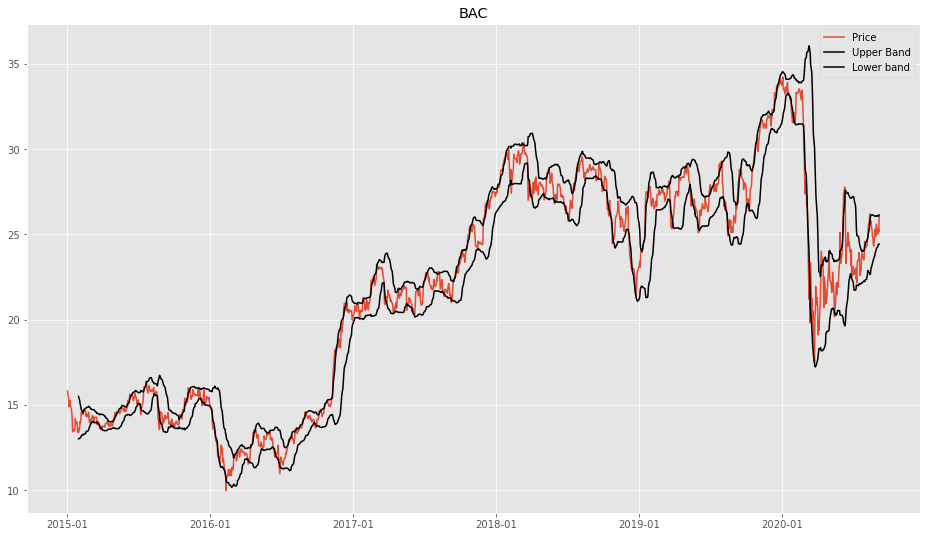

In [ ]:
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2020,9,7)
#tickers = ['AAPL', 'KO', 'MSFT', 'TSLA', 'AMZN','BAC']
ticker = 'BAC'
#results = pd.DataFrame(columns = ['Ticker', 'RSI'])
data = web.DataReader(ticker, 'yahoo', start, end)
data = data.drop(columns = ['High', 'Low', 'Open', 'Close'])
data['20_MA'] = data['Adj Close'].rolling(20).mean()
data['20_std'] = data['Adj Close'].rolling(20).std()
data['Upper_band'] = data['20_MA'] + 1.65 * data['20_std']
data['Lower_band'] = data['20_MA'] - 1.65 * data['20_std']



plt.figure(figsize=(16,9))
ax1 = plt.subplot2grid((1,1), (0,0), rowspan = 1, colspan = 1, title = ticker)
ax1.plot(data['Adj Close'], label = 'Price')
ax1.plot(data['Upper_band'], label = 'Upper Band', color = 'black')
ax1.plot(data['Lower_band'], label = 'Lower band', color = 'black')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax1.legend()
plt.show()         

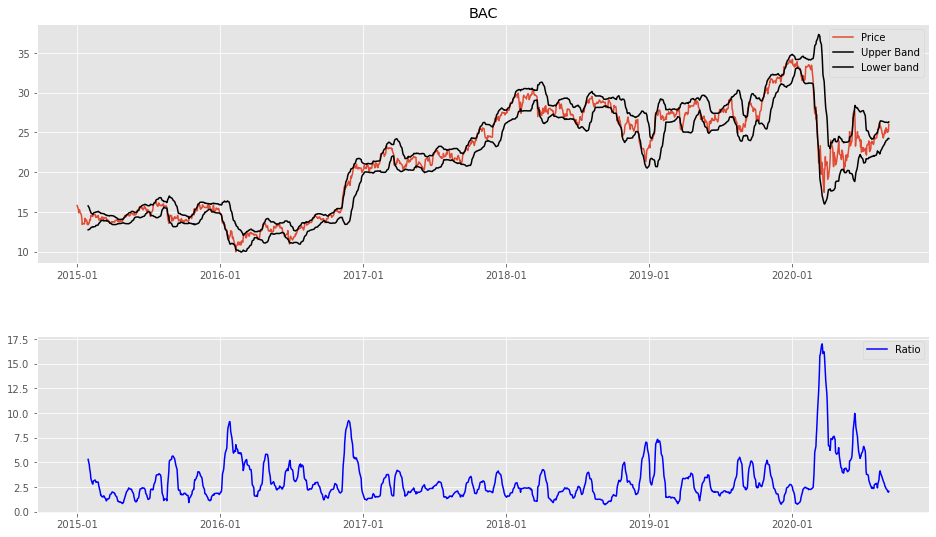

In [ ]:
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2020,9,7)
tickers = ['AAPL', 'KO', 'MSFT', 'TSLA', 'AMZN','BAC']
ticker = 'BAC'
results = pd.DataFrame(columns = ['Ticker', 'RSI'])
data = web.DataReader(ticker, 'yahoo', start, end)
data = data.drop(columns = ['High', 'Low', 'Open', 'Close'])
data['20_MA'] = data['Adj Close'].rolling(20).mean()
data['20_std'] = data['Adj Close'].rolling(20).std()
data['Upper_band'] = data['20_MA'] + 2 * data['20_std']
data['Lower_band'] = data['20_MA'] - 2 * data['20_std']
data['Ratio'] = data['20_std'] / data['20_MA'] * 100


plt.figure(figsize=(16,9))
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 4, colspan = 1, title = ticker)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1, sharex = ax1)
ax1.plot(data['Adj Close'], label = 'Price')
ax1.plot(data['Upper_band'], label = 'Upper Band', color = 'black')
ax1.plot(data['Lower_band'], label = 'Lower band', color = 'black')
ax2.plot(data['Ratio'], label = 'Ratio', color = 'blue')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax3.set_xlabel('Date (Year - month)')
ax1.legend()
ax2.legend()
plt.show()         

Misuriamo il ratio su più titoli - Uno "screener"

In [ ]:
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2021,11,26)
tickers = ['^GSPC','AAPL', 'KO', 'MSFT', 'TSLA', 'AMZN','BAC']

results = pd.DataFrame(columns = ['Ticker', 'Ratio'])

for ticker in tickers:
    data = web.DataReader(ticker, 'yahoo', start, end)
    data = data.drop(columns = ['High', 'Low', 'Open', 'Close'])
    data['20_MA'] = data['Adj Close'].rolling(20).mean()
    data['20_std'] = data['Adj Close'].rolling(20).std()
    data['Upper_band'] = data['20_MA'] + 2 * data['20_std']
    data['Lower_band'] = data['20_MA'] - 2 * data['20_std']
    data['Ratio'] = data['20_std'] / data['20_MA'] * 100
    
    new_row = {'Ticker': ticker, 'Ratio': data['Ratio'][-1]}
    results = results.append(new_row, ignore_index = True)

print(results)

  Ticker     Ratio
0  ^GSPC  0.743898
1   AAPL  3.166716
2     KO  1.318339
3   MSFT  1.185725
4   TSLA  6.043150
5   AMZN  2.915467
6    BAC  1.569692


### MACD con "Signal line" - 2

Moving average convergence divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. The MACD is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA.

The result of that calculation is the MACD line. A nine-day EMA of the MACD called the "signal line," is then plotted on top of the MACD line, which can function as a trigger for buy and sell signals. Traders may buy the security when the MACD crosses above its signal line and sell—or short—the security when the MACD crosses below the signal line. Moving average convergence divergence (MACD) indicators can be interpreted in several ways, but the more common methods are crossovers, divergences, and rapid rises/falls.

MACD=12-Period EMA − 26-Period EMA
﻿

MACD is calculated by subtracting the long-term EMA (26 periods) from the short-term EMA (12 periods). An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points.

The exponential moving average is also referred to as the exponentially weighted moving average. An exponentially weighted moving average reacts more significantly to recent price changes than a simple moving average (SMA), which applies an equal weight to all observations in the period.

Learning From MACD
The MACD has a positive value (shown as the blue line in the lower chart) whenever the 12-period EMA (indicated by the red line on the price chart) is above the 26-period EMA (the blue line in the price chart) and a negative value when the 12-period EMA is below the 26-period EMA. The more distant the MACD is above or below its baseline indicates that the distance between the two EMAs is growing.

In the following chart, you can see how the two EMAs applied to the price chart correspond to the MACD (blue) crossing above or below its baseline (dashed) in the indicator below the price chart.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [ ]:
start = dt.datetime(2020, 1, 27)
end = dt.datetime(2021,11,29)
ticker = 'AAPL'
data = web.DataReader(ticker, 'yahoo', start, end)

In [ ]:
exp1 = data['Close'].ewm(span=12, adjust = False).mean()
exp2 = data['Close'].ewm(span=26, adjust = False).mean()

In [ ]:
data['MACD'] = exp1 - exp2
data['Signal line'] = data['MACD'].ewm(span=9, adjust = False).mean()

In [ ]:
data.tail()

,High,Low,Open,Close,Volume,Adj Close,MACD,Signal line
Date,,,,,,,,
2021-11-22,165.699997,161.000000,161.679993,161.020004,117467900.0,161.020004,2.757100,1.682973
2021-11-23,161.800003,159.059998,161.119995,161.410004,96041900.0,161.410004,3.132270,1.972832
2021-11-24,162.139999,159.639999,160.750000,161.940002,69463600.0,161.940002,3.432791,2.264824
2021-11-26,160.449997,156.360001,159.570007,156.809998,76959800.0,156.809998,3.219890,2.455837
2021-11-29,161.190002,158.789993,159.369995,160.240005,88663200.0,160.240005,3.290013,2.622672


<IPython.core.display.Javascript object>


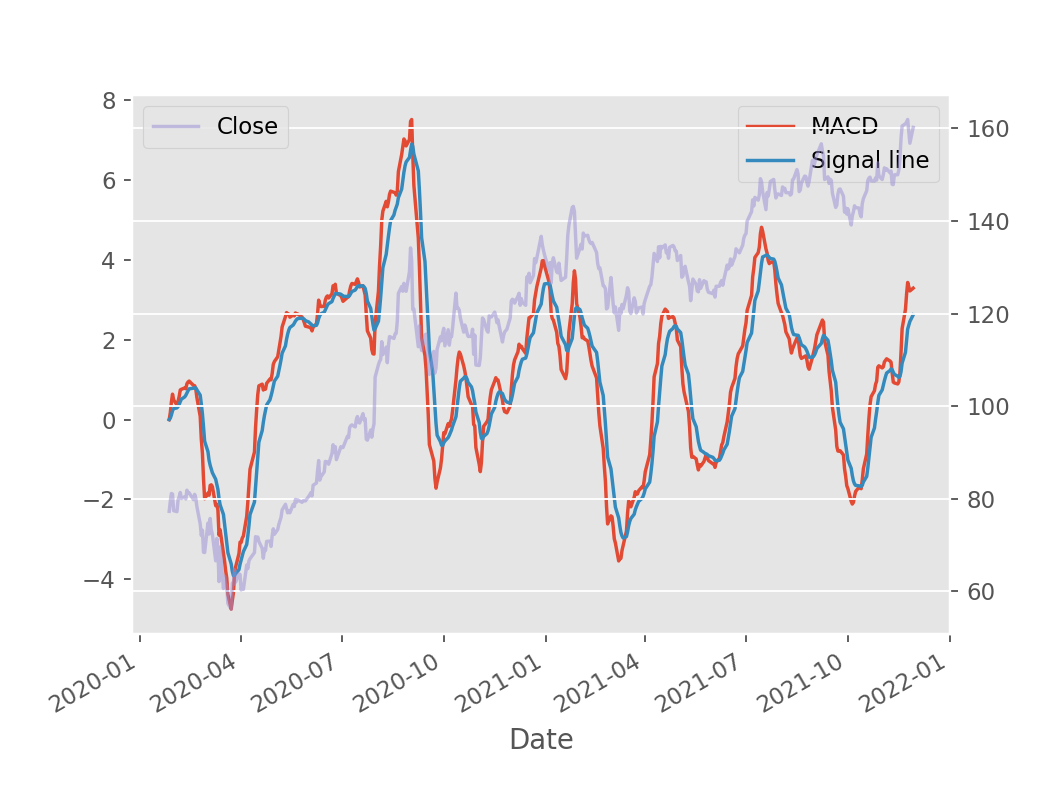

In [ ]:
fig, ax = plt.subplots()
data[['MACD', 'Signal line']].plot(ax=ax)
data['Close'].plot(ax = ax, alpha = 0.50, secondary_y = True)
plt.legend();

### Stocastic Oscillator

A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. The sensitivity of the oscillator to market movements is reducible by adjusting that time period or by taking a moving average of the result. It is used to generate overbought and oversold trading signals, utilizing a 0–100 bounded range of values.
The Formula for the Stochastic Oscillator Is
\begin{aligned} &\text{\%K}=\left(\frac{\text{C} - \text{L14}}{\text{H14} - \text{L14}}\right)\times100\\ &\textbf{where:}\\ &\text{C = The most recent closing price}\\ &\text{L14 = The lowest price traded of the 14 previous}\\ &\text{trading sessions}\\ &\text{H14 = The highest price traded during the same}\\ &\text{14-day period}\\ &\text{\%K = The current value of the stochastic indicator}\\ \end{aligned} 
  
%K=( 
H14−L14
C−L14
 )×100
where:
C = The most recent closing price
L14 = The lowest price traded of the 14 previous
trading sessions
H14 = The highest price traded during the same
14-day period
%K = The current value of the stochastic indicator
​
 
﻿

Notably, %K is referred to sometimes as the fast stochastic indicator. The "slow" stochastic indicator is taken as %D = 3-period moving average of %K.

The general theory serving as the foundation for this indicator is that in a market trending upward, prices will close near the high, and in a market trending downward, prices close near the low. Transaction signals are created when the %K crosses through a three-period moving average, which is called the %D.

The difference between the slow and fast Stochastic Oscillator is the Slow %K incorporates a %K slowing period of 3 that controls the internal smoothing of %K. Setting the smoothing period to 1 is equivalent to plotting the Fast Stochastic Oscillator.1﻿

What Does the Stochastic Oscillator Tell You?
The stochastic oscillator is range-bound, meaning it is always between 0 and 100. This makes it a useful indicator of overbought and oversold conditions. Traditionally, readings over 80 are considered in the overbought range, and readings under 20 are considered oversold. However, these are not always indicative of impending reversal; very strong trends can maintain overbought or oversold conditions for an extended period. Instead, traders should look to changes in the stochastic oscillator for clues about future trend shifts.

Stochastic oscillator charting generally consists of two lines: one reflecting the actual value of the oscillator for each session, and one reflecting its three-day simple moving average. Because price is thought to follow momentum, the intersection of these two lines is considered to be a signal that a reversal may be in the works, as it indicates a large shift in momentum from day to day.

Divergence between the stochastic oscillator and trending price action is also seen as an important reversal signal. For example, when a bearish trend reaches a new lower low, but the oscillator prints a higher low, it may be an indicator that bears are exhausting their momentum and a bullish reversal is brewing.



In [ ]:
high14 = data['High'].rolling(14).max()
low14 = data['Low'].rolling(14).min()
data['%K'] = (data['Close'] - low14) * 100 / (high14 - low14)
data['%D'] = data['%K'].rolling(3).mean()

In [ ]:
data.tail()

,High,Low,Open,Close,Volume,Adj Close,MACD,Signal line,%K,%D
Date,,,,,,,,,,
2021-11-22,165.699997,161.000000,161.679993,161.020004,117467900.0,161.020004,2.757100,1.682973,74.313983,87.897838
2021-11-23,161.800003,159.059998,161.119995,161.410004,96041900.0,161.410004,3.132270,1.972832,76.454484,82.432421
2021-11-24,162.139999,159.639999,160.750000,161.940002,69463600.0,161.940002,3.432791,2.264824,79.363369,76.710612
2021-11-26,160.449997,156.360001,159.570007,156.809998,76959800.0,156.809998,3.219890,2.455837,51.207471,69.008441
2021-11-29,161.190002,158.789993,159.369995,160.240005,88663200.0,160.240005,3.290013,2.622672,70.032980,66.867940


<IPython.core.display.Javascript object>


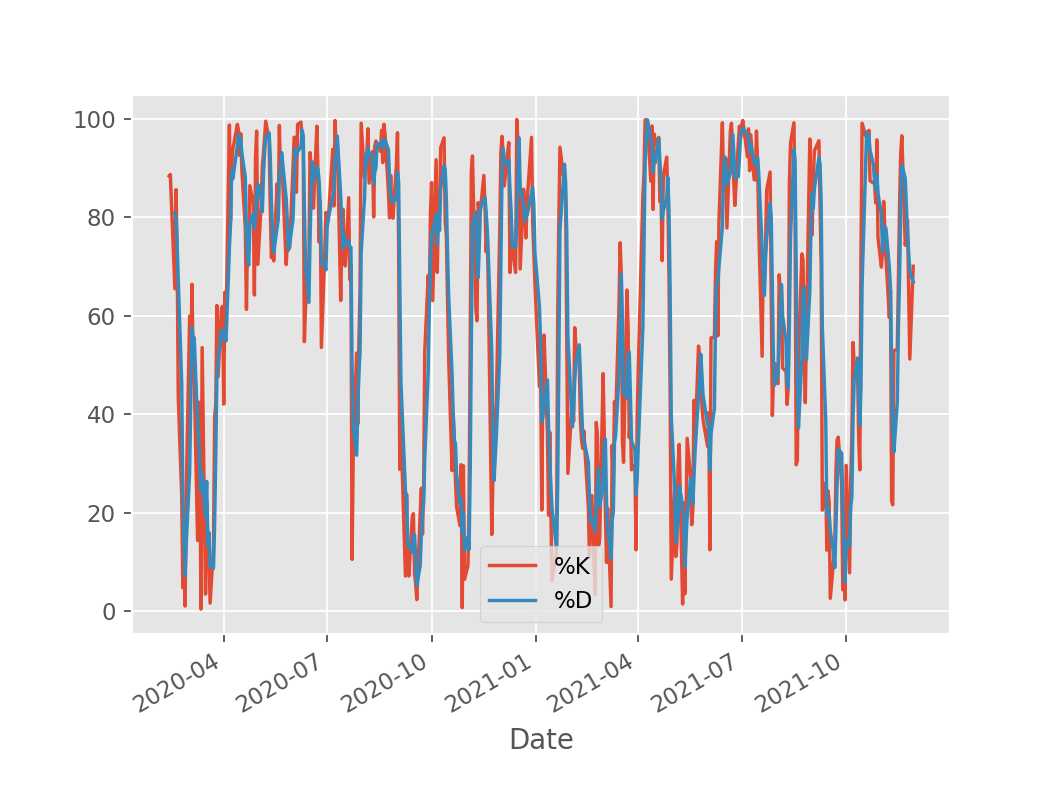

In [ ]:
fig, ax = plt.subplots()
data[['%K', '%D']].plot(ax=ax);

<IPython.core.display.Javascript object>


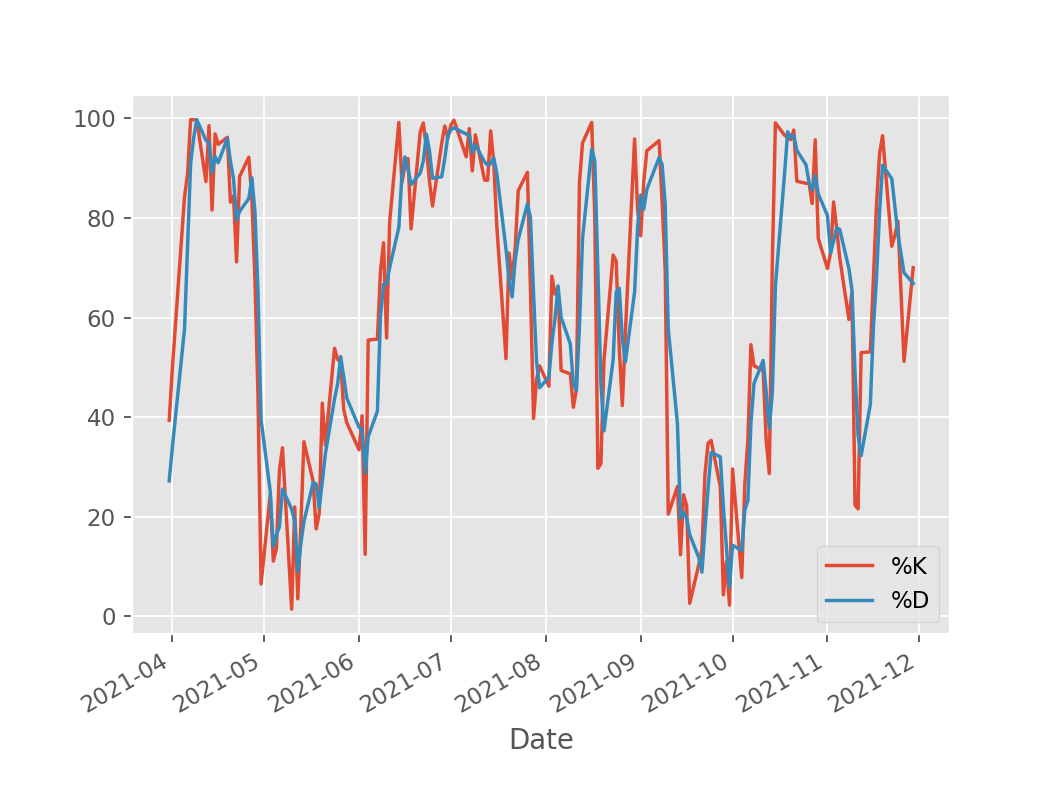

In [ ]:
fig, ax = plt.subplots()
data[['%K', '%D']].loc['2021-03-31':].plot(ax=ax);


In [ ]:
fig, ax = plt.subplots()
data[['%K', '%D']].loc['2021-03-31':].plot(ax=ax)
ax.axhline(80, c = 'r', alpha = 0.3)
ax.axhline(20, c='r', alpha = 0.3)
data['Close'].loc['2021-03-31':].plot(ax=ax, alpha = 0.3, secondary_y = True)
plt.legend();